In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

In [2]:
base_path = "/Users/annasommer/Documents/Documents - J73343QGPF/HRCM/CMSS2025/Practical_Sessions/"
runs = {
    "Albedo 0.06": base_path + "run_Climate_Ocean_Albedo_lat_006/output.nc",
    "Albedo 0.16": base_path + "run_Climate_Ocean_Albedo_lat_016/output.nc"
}


In [22]:
# --- HELPER FUNCTIONS ---
def area_weights(ds):
    """Compute cosine-latitude weights for global averaging"""
    weights = np.cos(np.deg2rad(ds.lat))
    return weights / weights.mean()

def seasonal_mean(ds, varname):
    """Return a DataArray grouped by season"""
    return ds[varname].groupby("time.season").mean("time")

def plot_seasonal_time_series_by_sim(datasets, varname, title, units):
    seasons = ["DJF", "MAM", "JJA", "SON"]
    colors = {
        "DJF": "tab:blue",
        "MAM": "tab:green",
        "JJA": "tab:orange",
        "SON": "tab:red"
    }

    plt.figure(figsize=(12,6))

    for label, ds in datasets.items():
        weights = area_weights(ds)

        # Surface temperature case
        if varname == 'temp':
            var = ds[varname].isel(layer=-1).weighted(weights).mean(dim=["lat", "lon"])
        else:
            var = ds[varname].weighted(weights).mean(dim=["lat", "lon"])

        # Add season and year as coordinates
        season = var["time.season"]
        year = var["time.year"]
        var.coords["season"] = season
        var.coords["year"] = year

        linestyle = "--" if "0.16" in label else "-"  # Dashed for perturbed run

        for season_name in seasons:
            try:
                # Extract values for this season, then group by year
                season_series = var.where(var.season == season_name, drop=True)
                yearly_mean = season_series.groupby("year").mean()
                plt.plot(
                    yearly_mean.year,
                    yearly_mean,
                    label=f"{label} - {season_name}",
                    color=colors[season_name],
                    linestyle=linestyle
                )
            except Exception as e:
                print(f"Skipping {label} - {season_name} due to error: {e}")

    plt.title(title)
    plt.ylabel(units)
    plt.xlabel("Year")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_timeseries(datasets, varname, title, units):
    plt.figure(figsize=(12,5))
    for label, ds in datasets.items():
        weights = area_weights(ds)
        if varname == 'temp':
            var = ds[varname].isel(layer=-1).weighted(weights).mean(dim=["lat", "lon"])
            plt.plot(ds.time, var, label=label)
        else: 
            var = ds[varname].weighted(weights).mean(dim=["lat", "lon"])
            plt.plot(ds.time[4:], var[4:], label=label)
    plt.title(title)
    plt.ylabel(units)
    plt.xlabel("Time")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_jet_stream(ds, label, level_idx=3):
    """Plot zonal wind at upper level (e.g. level=3 ≈ 200 hPa)"""
    u = ds["u"].isel(layer=level_idx)
    weights = area_weights(ds)
    u_zonal = u.mean(dim="lon")  # zonal mean
    u_mean = u_zonal.mean(dim="time")

    plt.plot(u_mean, ds.lat, label=label)

# --- FUNCTION: Compute DJF STD DEV of Surface Temperature ---
def seasonal_stddev(ds, varname, level=-1, season='DJF'):
    da = ds[varname]
    if "layer" in da.dims:
        da = da.isel(layer=level)
    da.coords["season"] = da["time.season"]
    da.coords["year"] = da["time.year"]
    da_season = da.where(da.season == season, drop=True)
    return da_season.groupby("year").mean("time").std("year")



# --- FUNCTION: Compute DJF STD DEV of Surface Temperature ---
def seasonal_stddev_all(ds, varname, level=-1, season='DJF'):
    da = ds[varname]
    if "layer" in da.dims:
        da = da.isel(layer=level)
    da.coords["season"] = da["time.season"]
    da.coords["year"] = da["time.year"]
    da_season = da.where(da.season == season, drop=True)
    return da_season.std("time")

In [4]:
# --- LOAD DATA ---
datasets = {label: xr.open_dataset(path) for label, path in runs.items()}


In [21]:
for label, ds in datasets.items():
    da = ds['temp']
    print(da["time.year"])

<xarray.DataArray 'year' (time: 87601)> Size: 701kB
array([2000, 2000, 2000, ..., 2029, 2029, 2029])
Coordinates:
  * time     (time) datetime64[ns] 701kB 2000-01-01 ... 2029-12-24
<xarray.DataArray 'year' (time: 87601)> Size: 701kB
array([2000, 2000, 2000, ..., 2029, 2029, 2029])
Coordinates:
  * time     (time) datetime64[ns] 701kB 2000-01-01 ... 2029-12-24


In [11]:
datasets["time.season"]

KeyError: 'time.season'

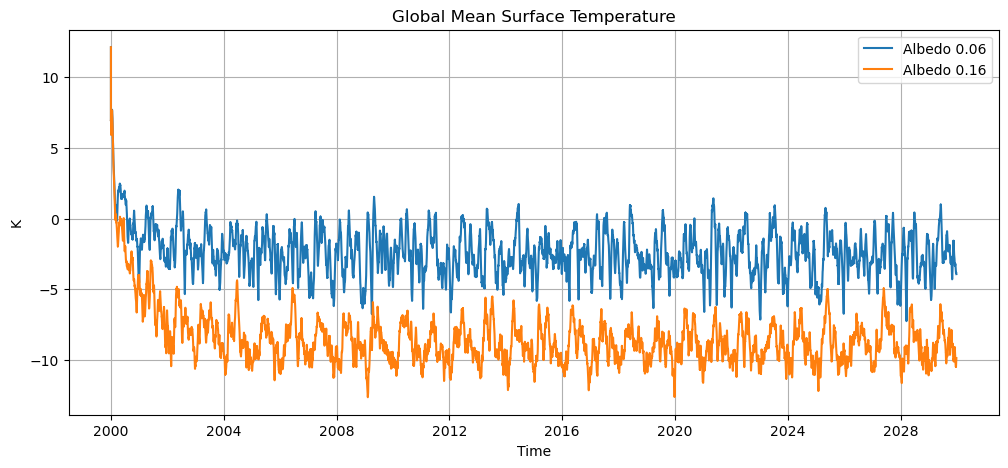

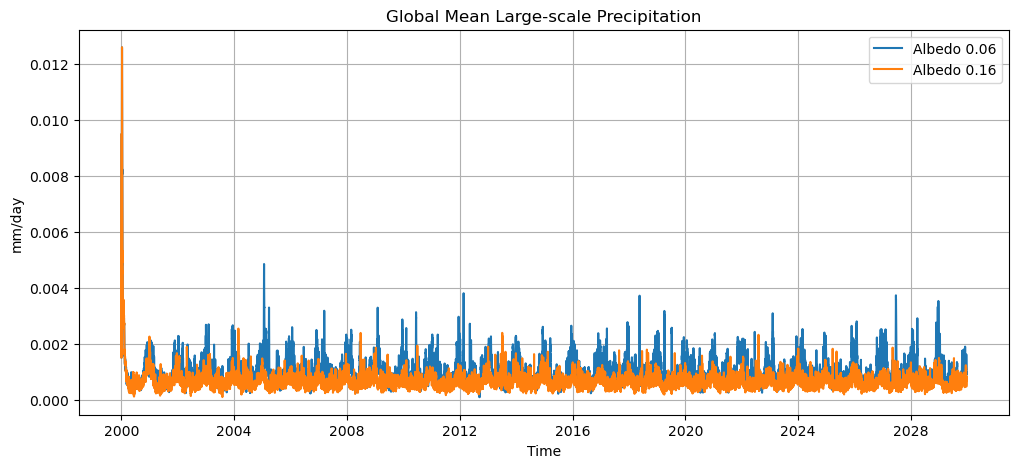

In [5]:
# --- PLOT GLOBAL MEANS ---
plot_timeseries(datasets, "temp", "Global Mean Surface Temperature", "K")
plot_timeseries(datasets, "precip_cond_rate", "Global Mean Large-scale Precipitation", "mm/day")


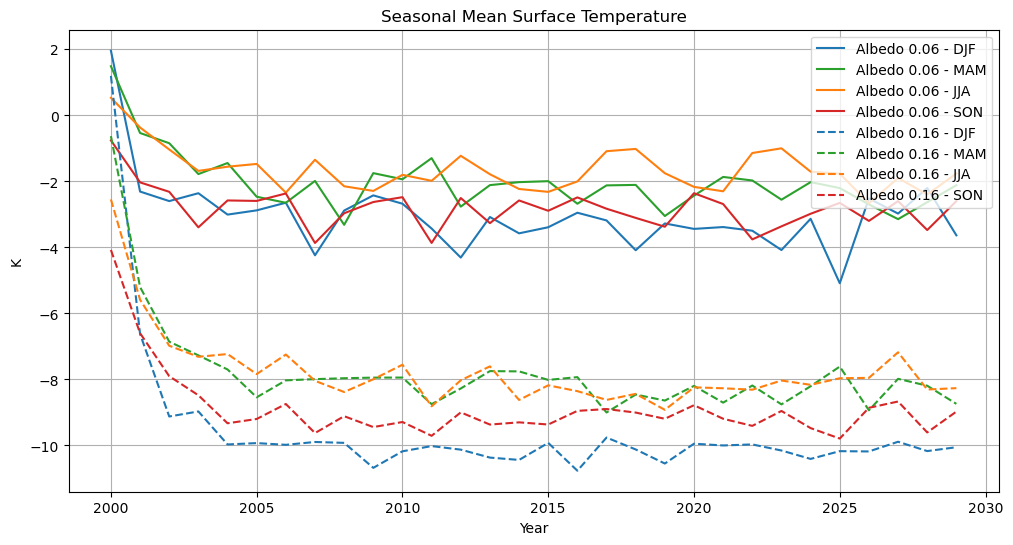

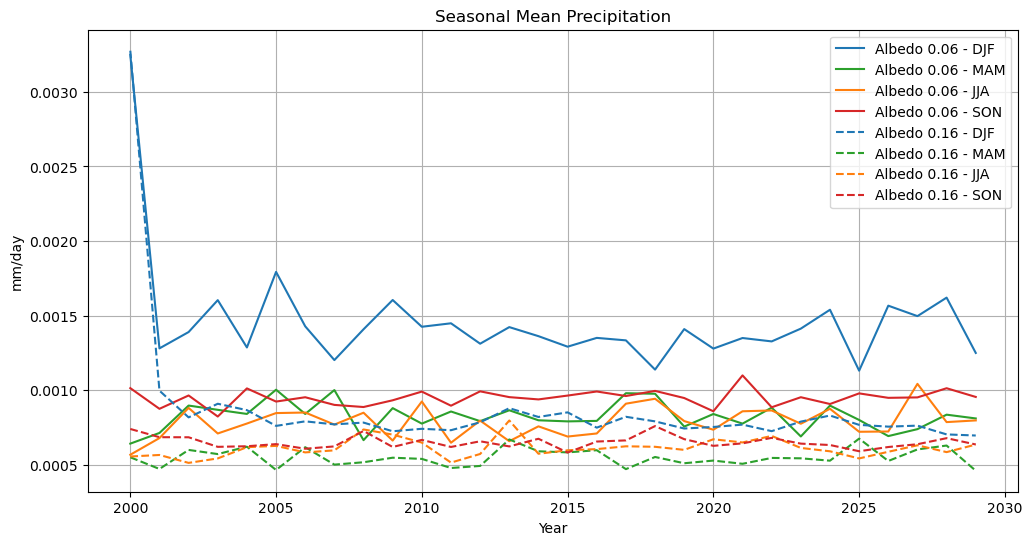

In [18]:
# --- SEASONAL MEANS ---
plot_seasonal_time_series_by_sim(datasets, "temp", "Seasonal Mean Surface Temperature", "K")
plot_seasonal_time_series_by_sim(datasets, "precip_cond_rate", "Seasonal Mean Precipitation", "mm/day")



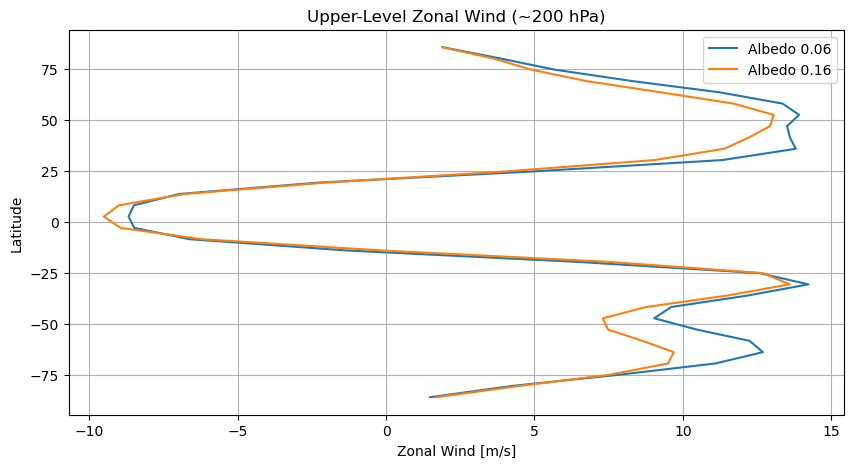

In [13]:
# --- ZONAL WIND / JET STREAM ---
plt.figure(figsize=(10,5))
for label, ds in datasets.items():
    plot_jet_stream(ds, label, level_idx=3)  # adjust level if needed
plt.title("Upper-Level Zonal Wind (~200 hPa)")
plt.xlabel("Zonal Wind [m/s]")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# --- CONFIGURATION ---
season = 'DJF'
varname = 'temp'
layer = -1  # Surface layer
units = "K"

In [7]:
# --- COMPUTE ---
std_dev = {label: seasonal_stddev(ds, varname, level=layer, season=season)
           for label, ds in datasets.items()}
std_diff = std_dev["Albedo 0.16"] - std_dev["Albedo 0.06"]

/Users/annasommer/anaconda3/envs/work/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


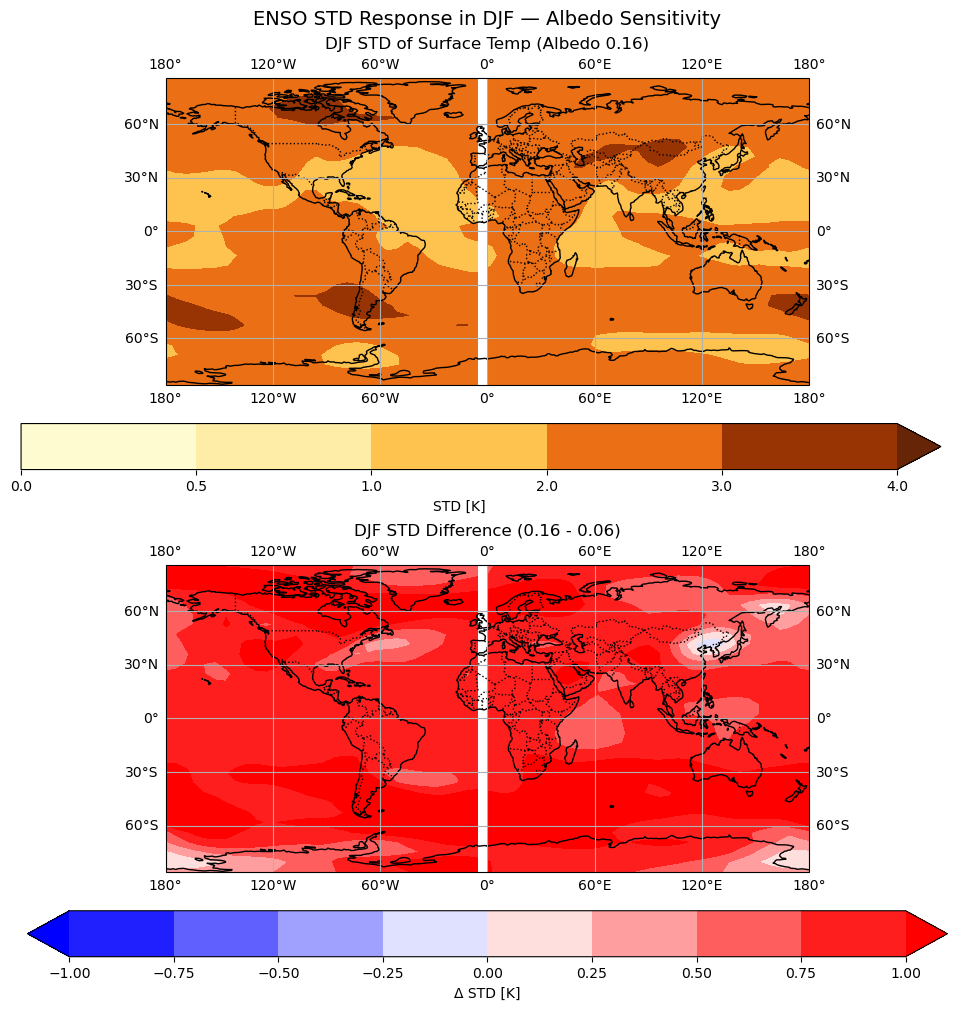

In [8]:
# --- PLOT ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

# --- Panel 1: STD for Albedo 0.16 ---
im1 = axs[0].contourf(std_dev["Albedo 0.16"].lon, std_dev["Albedo 0.16"].lat,
                      std_dev["Albedo 0.16"], levels=[0, 0.5, 1, 2, 3, 4],
                      cmap="YlOrBr", extend="max", transform=ccrs.PlateCarree())

axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=":")
axs[0].gridlines(draw_labels=True)
axs[0].set_title(f"{season} STD of Surface Temp (Albedo 0.16)")
plt.colorbar(im1, ax=axs[0], orientation="horizontal", label=f"STD [{units}]")

# --- Panel 2: Difference (Albedo 0.16 – 0.06) ---
im2 = axs[1].contourf(std_diff.lon, std_diff.lat, std_diff,
                      levels=np.linspace(-1, 1, 9), cmap="bwr", extend="both",
                      transform=ccrs.PlateCarree())

axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=":")
axs[1].gridlines(draw_labels=True)
axs[1].set_title(f"{season} STD Difference (0.16 - 0.06)")
plt.colorbar(im2, ax=axs[1], orientation="horizontal", label=f"Δ STD [{units}]")

plt.suptitle(f"ENSO STD Response in {season} — Albedo Sensitivity", fontsize=14)
plt.show()

In [23]:
# --- COMPUTE ---
std_dev_all = {label: seasonal_stddev_all(ds, varname, level=layer, season=season)
           for label, ds in datasets.items()}
std_diff_all = std_dev_all["Albedo 0.16"] - std_dev_all["Albedo 0.06"]

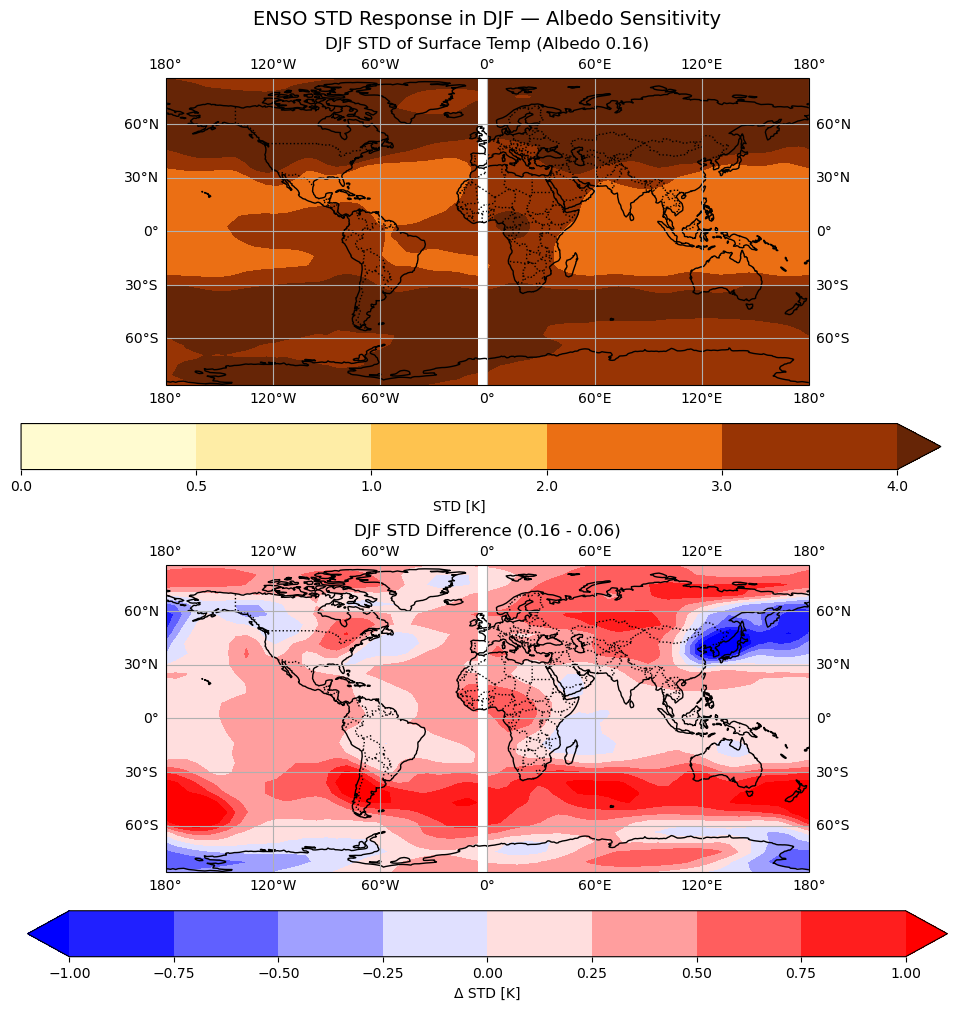

In [24]:
# --- PLOT ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

# --- Panel 1: STD for Albedo 0.16 ---
im1 = axs[0].contourf(std_dev_all["Albedo 0.16"].lon, std_dev_all["Albedo 0.16"].lat,
                      std_dev_all["Albedo 0.16"], levels=[0, 0.5, 1, 2, 3, 4],
                      cmap="YlOrBr", extend="max", transform=ccrs.PlateCarree())

axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=":")
axs[0].gridlines(draw_labels=True)
axs[0].set_title(f"{season} STD of Surface Temp (Albedo 0.16)")
plt.colorbar(im1, ax=axs[0], orientation="horizontal", label=f"STD [{units}]")

# --- Panel 2: Difference (Albedo 0.16 – 0.06) ---
im2 = axs[1].contourf(std_diff_all.lon, std_diff_all.lat, std_diff_all,
                      levels=np.linspace(-1, 1, 9), cmap="bwr", extend="both",
                      transform=ccrs.PlateCarree())

axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=":")
axs[1].gridlines(draw_labels=True)
axs[1].set_title(f"{season} STD Difference (0.16 - 0.06)")
plt.colorbar(im2, ax=axs[1], orientation="horizontal", label=f"Δ STD [{units}]")

plt.suptitle(f"ENSO STD Response in {season} — Albedo Sensitivity", fontsize=14)
plt.show()